## Imports von allen genutzten Librarys

In [1]:
import librosa
import numpy as np
import os
import copy

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

Der Dateipfad zu den Daten wird gesetzt.

In [2]:
# setting up the data directory
DATA_DIR="cats_dogs/"

Hier wird eine Sound-Klasse erstellt. Der Filepath ist der zu der Wav-Datei, "Cat" ist ein Boolean welches true ist, wenn es sich um die Audio einer Katze handelt und False, wenn es ein Hund ist.

In [3]:
class Sound:
    def __init__(self, filePath, cat, spec = None):
        self.filePath = filePath
        self.cat = cat
        self.spec = spec

    def __str__(self):
        return f"Sound(filePath={self.filePath}, cat={self.cat}, spec={self.spec})"
    

Hier wird die Liste an Sound Objekten initialisiert und gezählt, wie viele Hunde und Katzen Audios es gibt. Das Spektrogramm bleibt hierbei erstmal leer und wird gesondert berechnet.

## Data Unterstanding

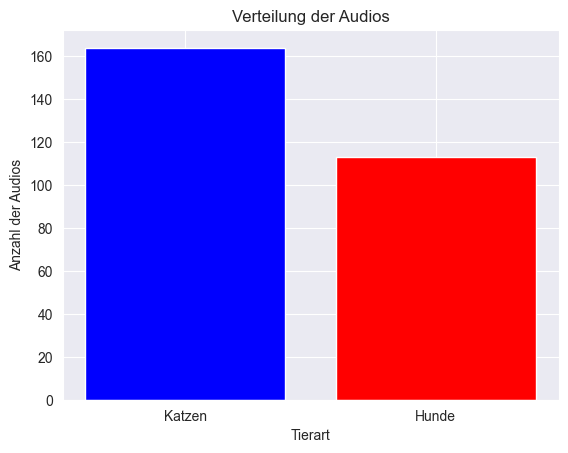

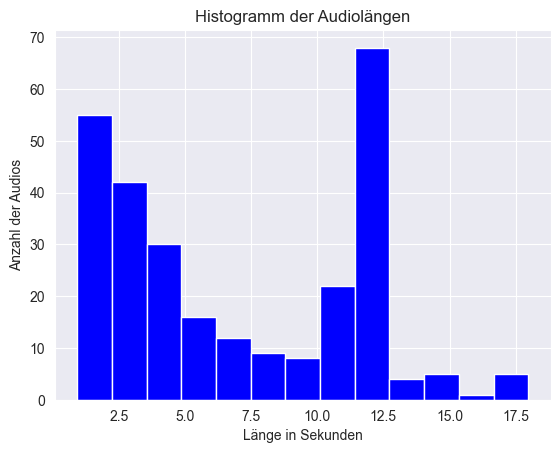

Targeted duration:  7.0
Number of Cat-Audios: 164
Number of Dog-Audios: 113


In [4]:
audiofiles = []
files = [f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
dog_counter = 0
cat_counter = 0

for file in files:
    isCat = file.split("_")[0] == "cat"
    if isCat:
        cat_counter += 1
    else:
        dog_counter += 1
    audiofiles.append(Sound(filePath=DATA_DIR+file ,cat=isCat))

labels = ['Katzen', 'Hunde']
counts = [cat_counter, dog_counter]

plt.bar(labels, counts, color = ['blue', 'red'])

plt.title ('Verteilung der Audios')
plt.xlabel ('Tierart')
plt.ylabel('Anzahl der Audios')

plt.show()


audio_lengths = []
for audiofile in audiofiles:
    y, sr = librosa.load(audiofile.filePath)
    audio_lengths.append(librosa.get_duration(y=y, sr=sr))

plt.hist(audio_lengths, bins=13, color='blue')
plt.title('Histogramm der Audiolängen')
plt.xlabel('Länge in Sekunden')
plt.ylabel('Anzahl der Audios')
plt.show()

TARGETDURATION = np.ceil(np.mean(audio_lengths))

print("Targeted duration: ", TARGETDURATION)
print ("Number of Cat-Audios:", cat_counter)
print ("Number of Dog-Audios:", dog_counter)


Hier sehen wir an dem Verhältnis von Katzen zu Hunde-Audios, dass diese nicht perfekt gleich verteilt sind und mehr Hunde-Audiosignale existieren. 
Man möchte beim Training keine Klasse unterrepräsentieren, weswegen diese Information wichtig ist und in späteren Schritten noch wichtig wird.
Die durchschnittliche Länge der Audiosignale ist bei ca. 7 Sekunden. Dieser Wert wird später noch Wichtig, da die Spectrogramme alle auf die gleiche Länge gebracht werden müssen.

## Das Spectrogramm

Die Funktion getMelSpecLabel erstellt ein Spectrogramm auf Basis einer eines Sound Objectes (wie oben definiert) und füllt das spec-Attribut mit dem Mel Spectrogramm (als 2d numpy Array)
Dieses 2d Array kann daraufhin mithilfe der plotMel-Funktion visualisiert werden

In [5]:
def getMelSpecLabel(audiofile:Sound):
    y, sr = librosa.load(audiofile.filePath)
    # Passing through arguments to the Mel filters
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                        fmax=8000)
    audiofile.spec = librosa.power_to_db(S, ref=np.max)

def plotMel(audiofile:Sound):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(audiofile.spec, x_axis='time',
                                   y_axis='mel',
                                   fmax=8000, ax=ax)
    if audiofile.cat:
        ax.set(title="Cat")
    else:
        ax.set(title="Dog")
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

### Beispiel:

Hier wird kurz gezeigt, wie dieses 2d-Array aussieht, und wie diese Werte in ein Bild übersetzt aussehen. Die Werte, die in dem 2d-Array gezeigt werden, sind letzten Endes auch die, die als Input ins Neuronale Netz gelangen.

[[-58.61299  -41.643627 -37.16182  ... -65.08957  -64.84053  -63.39923 ]
 [-65.794785 -56.060455 -54.005676 ... -66.68897  -62.772957 -58.957684]
 [-74.54154  -61.993736 -55.103016 ... -64.10698  -59.95697  -57.796425]
 ...
 [-76.15093  -63.55017  -53.9777   ... -80.       -80.       -80.      ]
 [-76.17961  -64.40683  -56.657074 ... -80.       -80.       -80.      ]
 [-80.       -78.376816 -70.65631  ... -80.       -80.       -80.      ]]


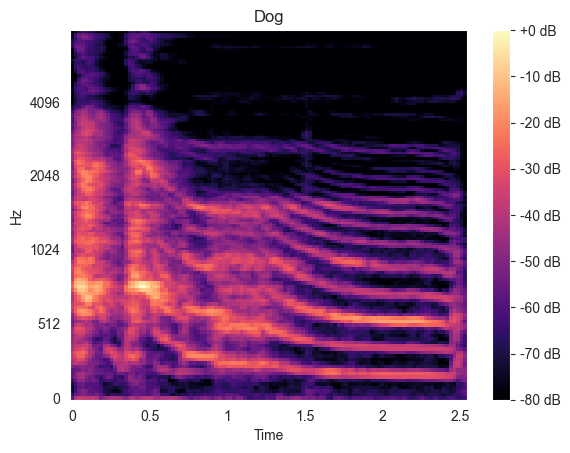

In [6]:
num = 3
processedData = getMelSpecLabel(audiofile=audiofiles[num])
print(audiofiles[num].spec)
plotMel(audiofiles[num])

## Rezising

Als nächtes nehmen wir die Information aus dem Data Unterstanding und sorgen dafür, dass alle Spectrogramme die gleiche Länge (7 Sekudnen) haben. Hierfür sind 2 Funktionen implementiert, welche in der Hausarbeit erklärt werden und jeweils Padding und Turncating implementieren.
Next we have to Resize all Spectogramms to the same input shape. By converting into a mel spectogramm every Spectotramm has a heigt (first dimension) of 128, the second demension should have a length of 311

In [7]:
def pad_resize(audiofile:Sound, width:int):
    if audiofile.spec.shape[1] > width:
      audiofile.spec = audiofile.spec[:, :width]
    else:
        counter = 0
        while audiofile.spec.shape[1] < width:
            new_column = np.array([audiofile.spec[:, counter]]).reshape(128,1)
            audiofile.spec = np.hstack((audiofile.spec, new_column))
            counter += 1

def pad_nulls(audiofile:Sound, width:int):
    if audiofile.spec.shape[1] > width:
        audiofile.spec = audiofile.spec[:, :width]
    else:
        counter = 0
        while audiofile.spec.shape[1] < width:
            audiofile.spec = np.hstack((audiofile.spec, np.zeros(shape=(128,1))))
            counter += 1


## Data Augmentation

Hier werden synthetisch neue Datensätze durch Data Augmentation erstellt. Speziell wird mit einer gewissen Wahrscheinlichkeit operiert, sodass ca. 20% - 30% der fürs Training genutzten Datensätze synthetisch hergestellt sind. Auch ist es um 10% wahrscheinlicher, dass neue Katzendatensätze erstellt werden als für Hunde, damit die ungleiche Verteilung bei der Menge der Trainingsdaten ausgeglichen werden.

In [8]:
def mask_random(Sound, mask_probability=0.15):
    newSound = copy.deepcopy(Sound) 
    arr = newSound.spec
    new = False 
    if newSound.cat:
        mask_probability = 0.30
    if np.random.rand() < mask_probability:
        mask_rows = np.random.choice([True, False])
        new = True 

        if mask_rows:
            num_rows = arr.shape[0]
            min_rows_to_mask = max(1, int(0.075 * num_rows))  
            max_rows_to_mask = min(int(0.20 * num_rows), num_rows)  
            num_rows_to_mask = np.random.randint(min_rows_to_mask, max_rows_to_mask + 1)  
            start_row = np.random.randint(0, num_rows - num_rows_to_mask + 1) 
            arr[start_row:start_row + num_rows_to_mask, :] = 0  
        else:
            num_cols = arr.shape[1]
            min_cols_to_mask = max(1, int(0.075 * num_cols))
            max_cols_to_mask = min(int(0.20 * num_cols), num_cols)
            num_cols_to_mask = np.random.randint(min_cols_to_mask, max_cols_to_mask + 1) 
            start_col = np.random.randint(0, num_cols - num_cols_to_mask + 1) 
            arr[:, start_col:start_col + num_cols_to_mask] = 0 

    return newSound, new

### Beispiel:

Diese Beispiel zeigt wie wie die mask_radnom funktion die Data Augmentation umsetzt.

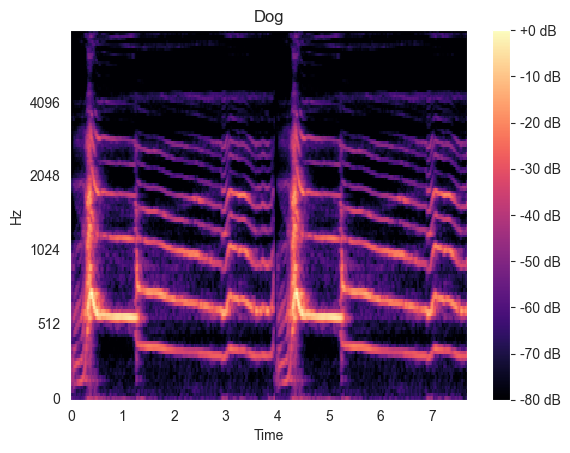

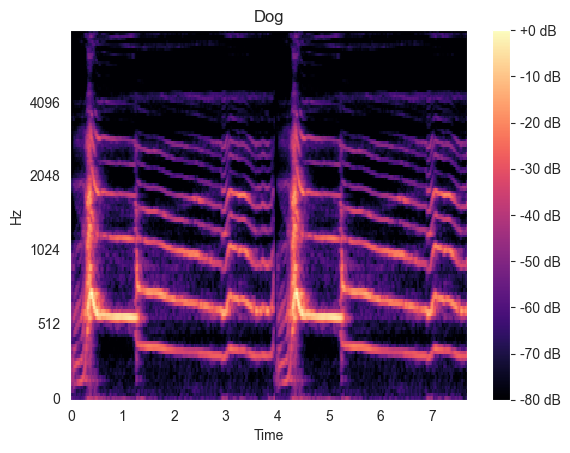

In [9]:
num = 1
getMelSpecLabel(audiofiles[num])
pad_resize(audiofiles[num], 331)
plotMel(audiofiles[num])

# Hier sieht man nur hin und wieder die Maskierung. Wenn die jedes mal gezeigt werden soll, muss die mask_probability = 1 gesetzt werden.
newSound, new = mask_random(audiofiles[num])
plotMel(newSound)

### Data Preparation

Hier werden alle genannten Data Preparation Methoden genutzt um die Daten fürs Modell vorzubereiten. Hierzu zählt eine Liste An Labels ("Dog" oder "Cat") und die Liste an Features (Spectrogrammen) Hierbei ist es Wichtig, dass beide Listen in der gleichen Reihenfolge sind, also das feature[x] mit dem label [x] korreliert. Zudem wird die Form(shape) von den Spectrogrammen verändert, sodass diese in der neuen Form ins Trainingsmodell eingefügt werden können.

#### Hinweis:

Es werden wenn neue Datensätze erstellt werden auch diese extra gelabelt

In [10]:
features = []
label = []

def init_features(audiofile):
    features.append(audiofile.spec.reshape((128,331,1)))
    if audiofile.cat:
        label.append("Cat")
    else:
        label.append("Dog")
        
for audiofile in audiofiles:
    getMelSpecLabel(audiofile=audiofile)
    pad_resize(audiofile=audiofile, width=331)
    modified_array, new_array_created  = mask_random(audiofiles[num])
    init_features(audiofile)
    if new_array_created:
        audiofiles.append(modified_array)
        init_features(modified_array)

features = np.array(features)
labels = np.array(label)

def one_hot(array):
    unique, inverse = np.unique(labels, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot
encoded_labels = one_hot(labels)

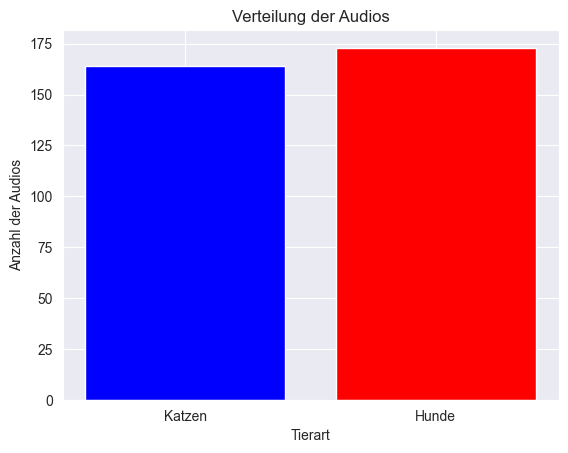

In [11]:
dog_counter = 0
cat_counter = 0

for audiofile in audiofiles:
    if audiofile.cat:
        cat_counter += 1
    else:
        dog_counter += 1

labels = ['Katzen', 'Hunde']
counts = [cat_counter, dog_counter]

plt.bar(labels, counts, color = ['blue', 'red'])

plt.title ('Verteilung der Audios')
plt.xlabel ('Tierart')
plt.ylabel('Anzahl der Audios')

plt.show()

In [12]:
features[0].shape

(128, 331, 1)

## The Model

Hier wird das Modell definiert und compiliert. Weiter unten ist eine Zusammenfassung des Modells sichtbar.

In [13]:
model = keras.Sequential(layers=[
        # input shape aller daten muss gleich sein -> deswegen resizing funktion
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(2, activation=keras.activations.softmax)
    ])
# warum adam _> keine ahnung
# legacy -> weil training auf m2 chip nicht mit dem normalen geht
model.compile(optimizer=keras.optimizers.legacy.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 331, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 165, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 165, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 82, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 83968)             0         
                                                                 
 dense (Dense)               (None, 64)                5

### Modell Training

Hier werden die Hyperparameter gesetzt, die Daten in Training und Testdaten geteilt und das Modell trainiert.
Hierbei wird wie in der Ausarbeitung beschrieben ein early stopping eingesetzt.

In [14]:
TEST_SIZE = 0.2

# 2^x gewählt weil -> macht man halt so
BATCH_SIZE = 48
EPOCHS = 50

X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=TEST_SIZE)

# Train the model

# val Daten fürs early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/50
6/6 [==============================] - 1s 116ms/step - loss: 157.2723 - accuracy: 0.4783 - val_loss: 18.4278 - val_accuracy: 0.5625
Epoch 2/50
6/6 [==============================] - 1s 106ms/step - loss: 16.5358 - accuracy: 0.6166 - val_loss: 7.5815 - val_accuracy: 0.6875
Epoch 3/50
6/6 [==============================] - 1s 105ms/step - loss: 4.9349 - accuracy: 0.6957 - val_loss: 0.8431 - val_accuracy: 0.7969
Epoch 4/50
6/6 [==============================] - 1s 106ms/step - loss: 1.6002 - accuracy: 0.8340 - val_loss: 0.6726 - val_accuracy: 0.8750
Epoch 5/50
6/6 [==============================] - 1s 103ms/step - loss: 0.5537 - accuracy: 0.9289 - val_loss: 1.2986 - val_accuracy: 0.8750
Epoch 6/50
6/6 [==============================] - 1s 105ms/step - loss: 0.1370 - accuracy: 0.9684 - val_loss: 0.1754 - val_accuracy: 0.9531
Epoch 7/50
6/6 [==============================] - 1s 106ms/step - loss: 0.0815 - accuracy: 0.9842 - val_loss: 0.1702 - val_accuracy: 0.9531
Epoch 8/50
6/6 [

### Ergebnisse

Im folgenden Teil sind die Ergebnisse zu sehen. Bzw bis zu wie vielen Epochen trainiert wurde und wie die Performance sich über die Zeit verändert hat

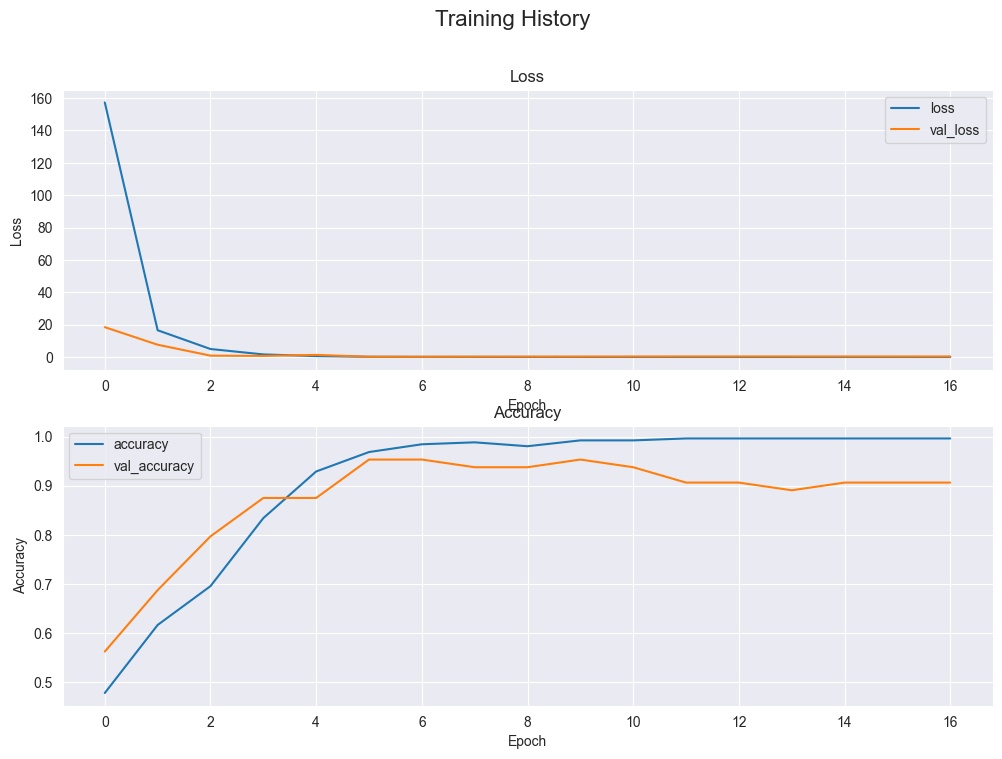

In [15]:
# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

#### weitere Metriken

3/3 [==============================] - 0s 26ms/step


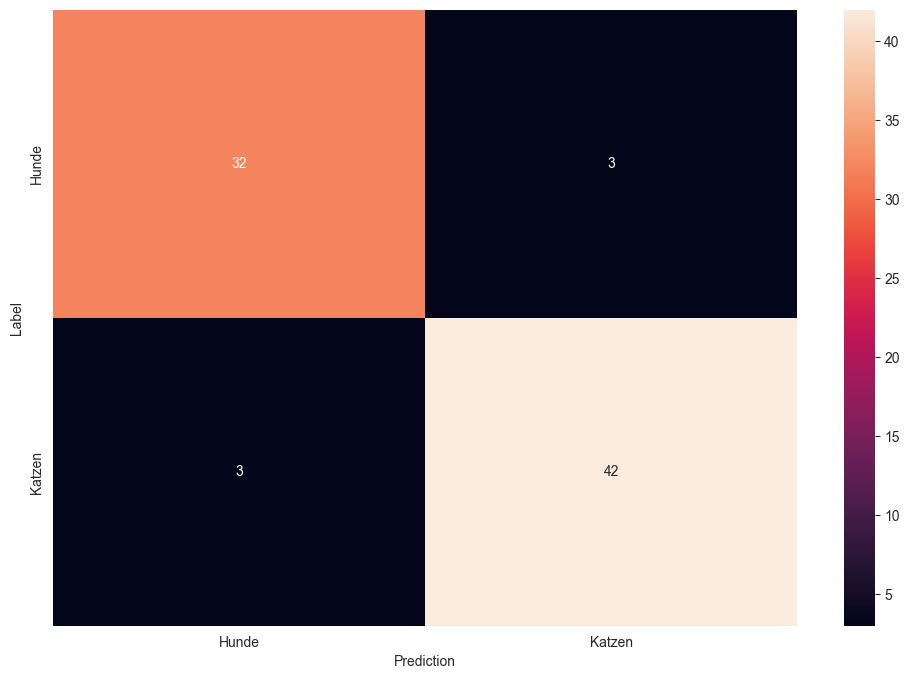

In [16]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Beispiel

Hier ist eine Predict Funktion implementiert in die man Sound Objekte geben kann und diese Predicten lassen kann. Sie können z.B: ihr eigenen Haustier aufnehmen und schauen ob das Modell es erkennt.

In [17]:
def predict(audio:Sound):
    getMelSpecLabel(audio)
    pad_resize(audio, 331)
    audio.spec = audio.spec.reshape((1,128,331,1))
    return model.predict(x=sound1.spec)

In [18]:
sound1 = Sound(DATA_DIR + "cat_3.wav", True)
print(predict(sound1))

1/1 [==============================] - 0s 20ms/step
[[0.99633384 0.00366616]]


## Schluss

Vielen Dank für ihre Aufmerksamkeit. Bei fragen zu den Entscheidungen, die zu diesem Notebook/Modell geführt haben verweisen wir auf die zugehörige Hausarbeit